In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler



In [4]:
df_all = pd.read_csv('file2.csv')

In [5]:
df_all.head()

,Unnamed: 0,date,user,text,results,polarity,subjectivity,sentiment
0,0,2009-06-24,caitlingeiger,camtronsummerswont know untilget new work sche...,"{'polarity': 0.13636363636363635, 'subjectivit...",0.136364,0.454545,Positive
1,1,2009-06-15,mad_vtak,also togood friend congrats man engaged im hap...,"{'polarity': 0.8, 'subjectivity': 1.0, 'sentim...",0.800000,1.000000,Positive
2,2,2009-05-18,stupid_doll_,yaaaay finally,"{'polarity': 0.0, 'subjectivity': 1.0, 'sentim...",0.000000,1.000000,Neutral
3,3,2009-06-02,Geeklawyer,manxstef spoke canon take elstree ffs drive lo...,"{'polarity': -0.060714285714285714, 'subjectiv...",-0.060714,0.307143,Negative
4,4,2009-06-02,DrunkenNyt,simply orange thee best juice ever made,"{'polarity': 0.5, 'subjectivity': 0.3285714285...",0.500000,0.328571,Positive


In [7]:
df_all=df_all.drop(columns=['Unnamed: 0'])


KeyError: "['Unnamed: 0'] not found in axis"

In [8]:
df_all['date'] = pd.to_datetime(df_all['date'])
tweets_per_day = df_all.groupby(df_all['date'].dt.date)['text'].count()
tweets_per_day = pd.DataFrame(tweets_per_day)
tweets_per_day.head()

,text
date,
2009-04-06,4313
2009-04-07,22298
2009-04-17,3888
2009-04-18,27718
2009-04-19,34888


In [11]:
 # Разделяем данные на тренировочную и тестовую выборки
train = tweets_per_day[tweets_per_day.index < pd.to_datetime("2009-06-01").date()]
test = tweets_per_day[tweets_per_day.index >= pd.to_datetime("2009-06-01").date()]
test




,text
date,
2009-06-01,140452
2009-06-02,81629
2009-06-03,52834
2009-06-04,10009
2009-06-05,74304
2009-06-06,141565
2009-06-07,121726
2009-06-14,10727
2009-06-15,140123


In [13]:
# Масштабируем данные
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['text']])
test_scaled = scaler.transform(test[['text']])


In [15]:
# Функция для преобразования временного ряда в последовательности данных для обучения RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Задаем длину последовательности (количество временных шагов для обучения модели)
sequence_length = 7

# Создаем последовательности для обучения и тестирования
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Создаем и обучаем LSTM модель
model = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(sequence_length, 1)),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)





Epoch 1/100
2/2 [==============================] - 1s 41ms/step - loss: 0.1559
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1313
Epoch 4/100
2/2 [==============================] - 0s 18ms/step - loss: 0.1213
Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1112
Epoch 6/100
2/2 [==============================] - 0s 14ms/step - loss: 0.1041
Epoch 7/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0968
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0904
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0855
Epoch 10/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0829
Epoch 11/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0824
Epoch 12/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0827
Epoch 13/100
2/2 [==============================]

1/1 [==============================] - 0s 192ms/step


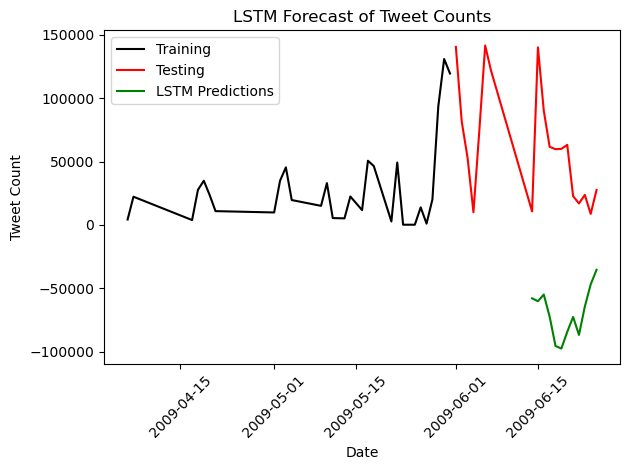

In [16]:
# Делаем прогноз на тестовой выборке
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Визуализируем результаты
plt.plot(train.index, train['text'], color='black', label='Training')
plt.plot(test.index, test['text'], color='red', label='Testing')
plt.plot(test.index[sequence_length:], y_pred, color='green', label='LSTM Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('LSTM Forecast of Tweet Counts')
plt.legend()
plt.tight_layout()
plt.show()

В этом примере мы добавили дополнительный LSTM слой с большим количеством нейронов и слой Dropout между слоями для снижения переобучения. Вы можете дальше экспериментировать с различными архитектурами и гиперпараметрами, чтобы улучшить прогнозы для вашего конкретного набора данных.

In [18]:
# Создаем последовательности для обучения и тестирования
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Создаем и обучаем LSTM модель с дополнительными слоями и регуляризацией
model = keras.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)



Epoch 1/100
2/2 [==============================] - 2s 109ms/step - loss: 0.1370
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1207
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0993
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0927
Epoch 5/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0816
Epoch 6/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0875
Epoch 7/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0872
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0877
Epoch 9/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0807
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0847
Epoch 11/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0793
Epoch 12/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0799
Epoch 13/100
2/2 [==============================

In [19]:
# Делаем прогноз на тестовой выборке
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)



1/1 [==============================] - 0s 360ms/step


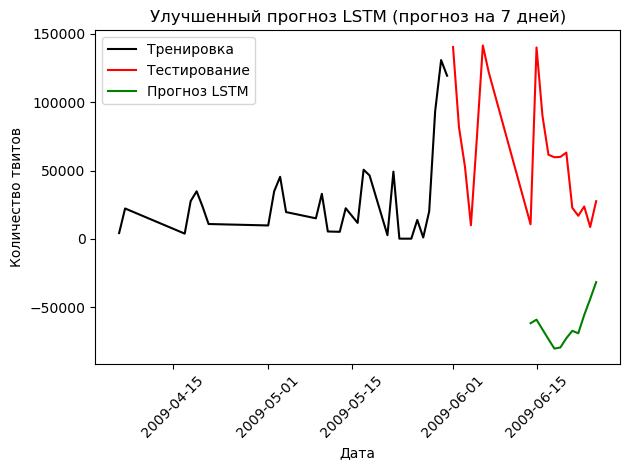

In [20]:
# Визуализируем результаты
plt.plot(train.index, train['text'], color='black', label='Тренировка')
plt.plot(test.index, test['text'], color='red', label='Тестирование')
plt.plot(test.index[sequence_length:], y_pred, color='green', label='Прогноз LSTM')
plt.ylabel('Количество твитов')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.title('Улучшенный прогноз LSTM (прогноз на 7 дней)')
plt.legend()
plt.tight_layout()
plt.show()

Training with dropout rate: 0.1
Epoch 1/100
2/2 [==============================] - 2s 157ms/step - loss: 0.1372
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 0.1197
Epoch 3/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1040
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0909
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0873
Epoch 6/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0853
Epoch 7/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0865
Epoch 8/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0834
Epoch 9/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0854
Epoch 10/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0806
Epoch 11/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0787
Epoch 12/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0794
Epoch 13/100
2/2

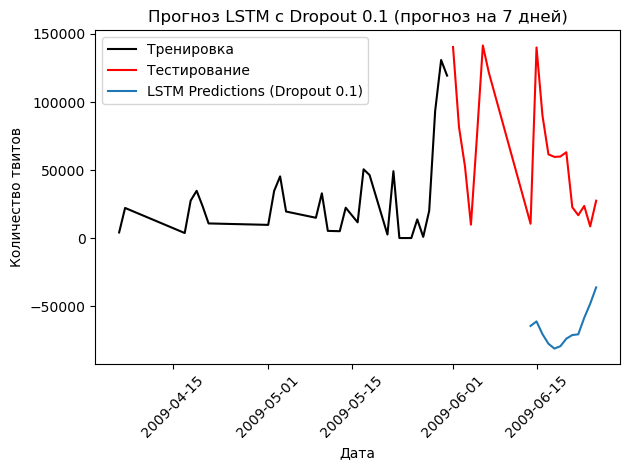

Training with dropout rate: 0.2
Epoch 1/100
2/2 [==============================] - 3s 161ms/step - loss: 0.1393
Epoch 2/100
2/2 [==============================] - 0s 80ms/step - loss: 0.1153
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0931
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 0.0891
Epoch 5/100
2/2 [==============================] - 0s 50ms/step - loss: 0.0857
Epoch 6/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0867
Epoch 7/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0886
Epoch 8/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0877
Epoch 9/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0848
Epoch 10/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0875
Epoch 11/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0805
Epoch 12/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0775
Epoch 13/100
2/2

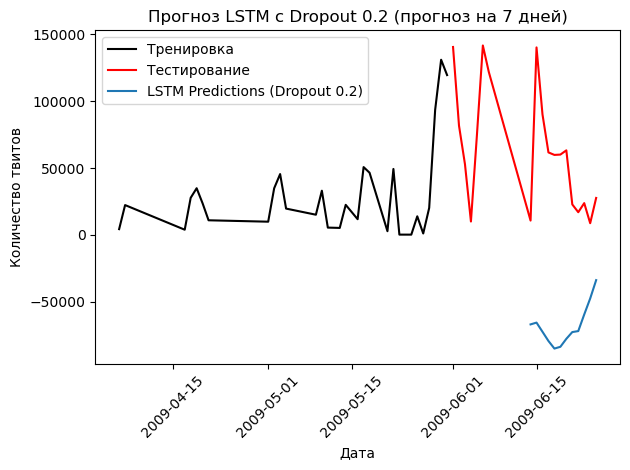

Training with dropout rate: 0.3
Epoch 1/100
2/2 [==============================] - 3s 138ms/step - loss: 0.1409
Epoch 2/100
2/2 [==============================] - 0s 64ms/step - loss: 0.1187
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 0.1001
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0887
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0820
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0876
Epoch 7/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0899
Epoch 8/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0884
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0934
Epoch 10/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0827
Epoch 11/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0837
Epoch 12/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0836
Epoch 13/100
2/2

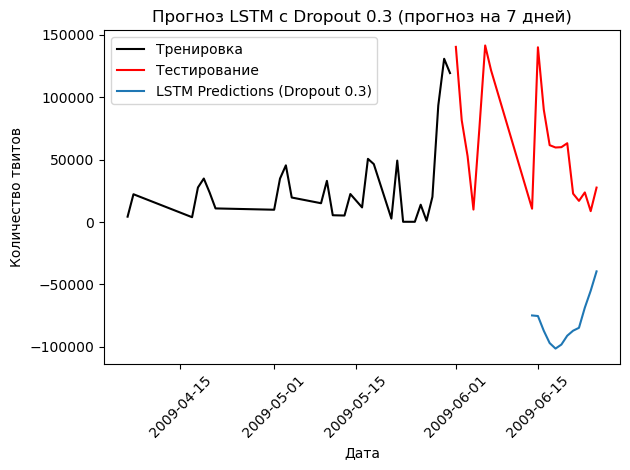

In [25]:
# Эксперимент с различными значениями dropout
dropout_values = [0.1, 0.2, 0.3]

for dropout_rate in dropout_values:
    print(f"Training with dropout rate: {dropout_rate}")
    model = keras.Sequential([
        keras.layers.LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.LSTM(50),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
    
    # Делаем прогноз на тестовой выборке
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    # Визуализируем результаты
    plt.plot(train.index, train['text'], color='black', label='Тренировка')
    plt.plot(test.index, test['text'], color='red', label='Тестирование')
    plt.plot(test.index[sequence_length:], y_pred, label=f'LSTM Predictions (Dropout {dropout_rate})')
    plt.ylabel('Количество твитов')
    plt.xlabel('Дата')
    plt.xticks(rotation=45)
    plt.title(f'Прогноз LSTM с Dropout {dropout_rate} (прогноз на 7 дней)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    


Training with L2 regularization: 0.001
Epoch 1/100
2/2 [==============================] - 3s 238ms/step - loss: 0.1344
Epoch 2/100
2/2 [==============================] - 0s 116ms/step - loss: 0.1180
Epoch 3/100
2/2 [==============================] - 0s 84ms/step - loss: 0.1008
Epoch 4/100
2/2 [==============================] - 0s 68ms/step - loss: 0.0898
Epoch 5/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0852
Epoch 6/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0952
Epoch 7/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0821
Epoch 8/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0841
Epoch 9/100
2/2 [==============================] - 0s 79ms/step - loss: 0.0860
Epoch 10/100
2/2 [==============================] - 0s 43ms/step - loss: 0.0858
Epoch 11/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0847
Epoch 12/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0831
Epoch 13

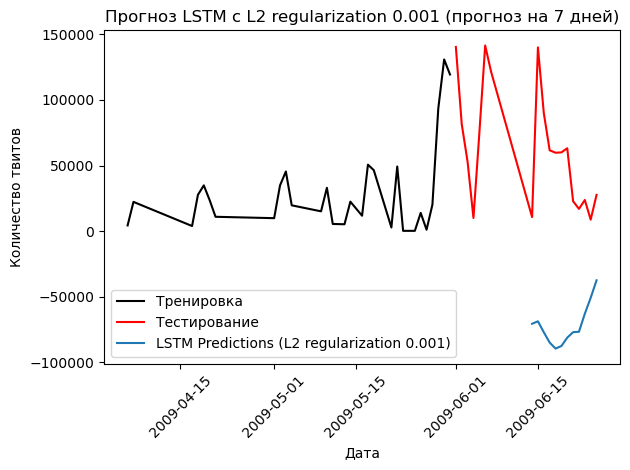

Training with L2 regularization: 0.01
Epoch 1/100
2/2 [==============================] - 2s 239ms/step - loss: 0.1573
Epoch 2/100
2/2 [==============================] - 0s 131ms/step - loss: 0.1355
Epoch 3/100
2/2 [==============================] - 0s 109ms/step - loss: 0.1200
Epoch 4/100
2/2 [==============================] - 0s 86ms/step - loss: 0.1051
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0996
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.1016
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 0.1054
Epoch 8/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0958
Epoch 9/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0992
Epoch 10/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0946
Epoch 11/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0973
Epoch 12/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0949
Epoch 13

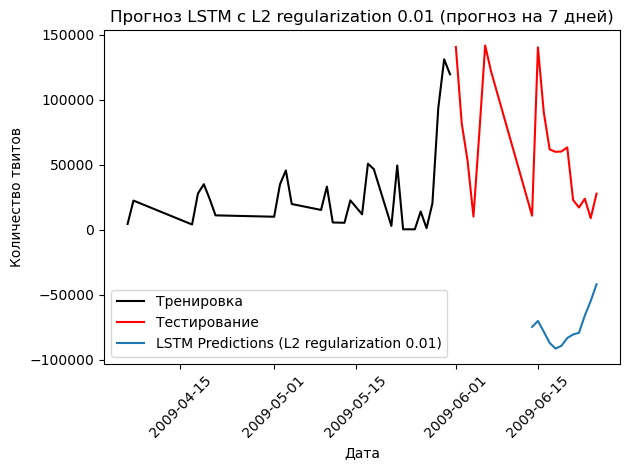

Training with L2 regularization: 0.1
Epoch 1/100
2/2 [==============================] - 3s 243ms/step - loss: 0.3296
Epoch 2/100
2/2 [==============================] - 0s 116ms/step - loss: 0.2978
Epoch 3/100
2/2 [==============================] - 0s 98ms/step - loss: 0.2762
Epoch 4/100
2/2 [==============================] - 0s 72ms/step - loss: 0.2530
Epoch 5/100
2/2 [==============================] - 0s 69ms/step - loss: 0.2359
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.2464
Epoch 7/100
2/2 [==============================] - 0s 56ms/step - loss: 0.2289
Epoch 8/100
2/2 [==============================] - 0s 32ms/step - loss: 0.2205
Epoch 9/100
2/2 [==============================] - 0s 48ms/step - loss: 0.2140
Epoch 10/100
2/2 [==============================] - 0s 32ms/step - loss: 0.2045
Epoch 11/100
2/2 [==============================] - 0s 42ms/step - loss: 0.1940
Epoch 12/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1932
Epoch 13/1

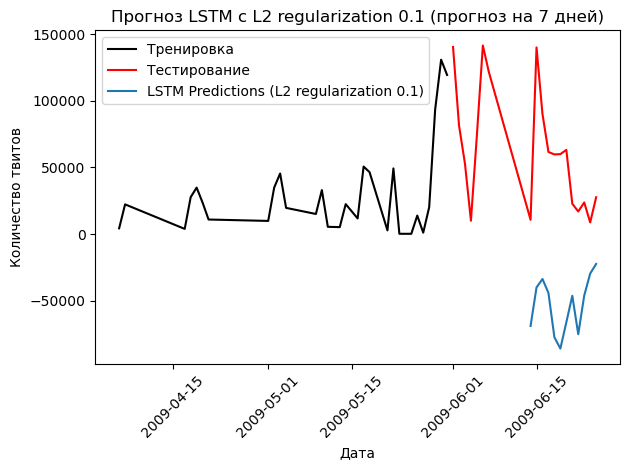

In [27]:
from tensorflow.keras import regularizers# Эксперимент с добавлением L2 регуляризации
l2_values = [0.001, 0.01, 0.1]

for l2_value in l2_values:
    print(f"Training with L2 regularization: {l2_value}")
    model = keras.Sequential([
        keras.layers.LSTM(100, return_sequences=True, input_shape=(sequence_length, 1),
                          kernel_regularizer=regularizers.l2(l2_value)),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(50),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

    # Делаем прогноз на тестовой выборке
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    # Визуализируем результаты
    plt.plot(train.index, train['text'], color='black', label='Тренировка')
    plt.plot(test.index, test['text'], color='red', label='Тестирование')
    plt.plot(test.index[sequence_length:], y_pred, label=f'LSTM Predictions (L2 regularization {l2_value})')
    plt.ylabel('Количество твитов')
    plt.xlabel('Дата')
    plt.xticks(rotation=45)
    plt.title(f'Прогноз LSTM с L2 regularization {l2_value} (прогноз на 7 дней)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
# Создаем и обучаем LSTM модель с L2 регуляризацией и dropout
model = keras.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(sequence_length, 1),
                      kernel_regularizer=regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50, kernel_regularizer=regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=130, batch_size=16, verbose=1)

Epoch 1/130
2/2 [==============================] - 3s 263ms/step - loss: 0.0742
Epoch 2/130
2/2 [==============================] - 0s 133ms/step - loss: 0.0754
Epoch 3/130
2/2 [==============================] - 0s 112ms/step - loss: 0.0805
Epoch 4/130
2/2 [==============================] - 0s 59ms/step - loss: 0.0799
Epoch 5/130
2/2 [==============================] - 0s 50ms/step - loss: 0.0782
Epoch 6/130
2/2 [==============================] - 0s 87ms/step - loss: 0.0782
Epoch 7/130
2/2 [==============================] - 0s 42ms/step - loss: 0.0806
Epoch 8/130
2/2 [==============================] - 0s 58ms/step - loss: 0.0777
Epoch 9/130
2/2 [==============================] - 0s 43ms/step - loss: 0.0799
Epoch 10/130
2/2 [==============================] - 0s 35ms/step - loss: 0.0825
Epoch 11/130
2/2 [==============================] - 0s 35ms/step - loss: 0.0803
Epoch 12/130
2/2 [==============================] - 0s 28ms/step - loss: 0.0769
Epoch 13/130
2/2 [============================

2/2 [==============================] - 0s 24ms/step - loss: 0.0790
Epoch 104/130
2/2 [==============================] - 0s 25ms/step - loss: 0.0790
Epoch 105/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0771
Epoch 106/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0787
Epoch 107/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0797
Epoch 108/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0783
Epoch 109/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0777
Epoch 110/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0793
Epoch 111/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0769
Epoch 112/130
2/2 [==============================] - 0s 25ms/step - loss: 0.0790
Epoch 113/130
2/2 [==============================] - 0s 25ms/step - loss: 0.0793
Epoch 114/130
2/2 [==============================] - 0s 24ms/step - loss: 0.0784
Epoch 115/130
2/2 [=======================

В данном случае, значение функции потерь уменьшилось с каждой эпохой, что говорит о том, что модель становится лучше настраиваться на обучающие данные.

In [37]:
# Делаем прогноз на тестовой выборке
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

1/1 [==============================] - 0s 450ms/step


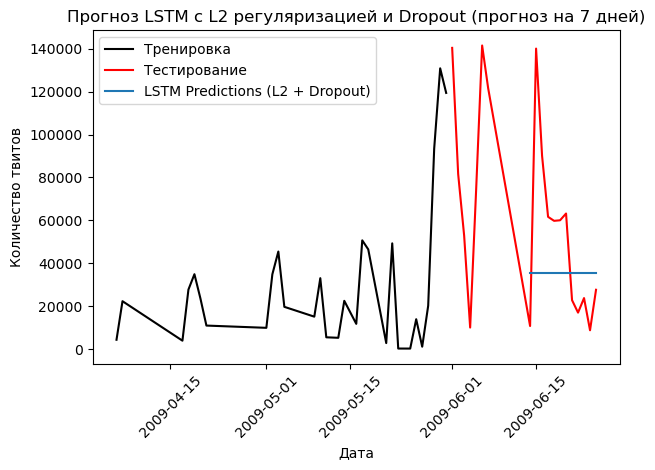

In [38]:
# Визуализируем результаты
plt.plot(train.index, train['text'], color='black', label='Тренировка')
plt.plot(test.index, test['text'], color='red', label='Тестирование')
plt.plot(test.index[sequence_length:], y_pred, label='LSTM Predictions (L2 + Dropout)')
plt.ylabel('Количество твитов')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.title('Прогноз LSTM с L2 регуляризацией и Dropout (прогноз на 7 дней)')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
from tensorflow.keras.layers import GRU, Conv1D

# Создаем и обучаем модель с GRU слоями
model_gru = keras.Sequential([
    GRU(100, return_sequences=True, input_shape=(sequence_length, 1),
        kernel_regularizer=regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),
    GRU(50, kernel_regularizer=regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)



Epoch 1/100
2/2 [==============================] - 4s 626ms/step - loss: 12.2969
Epoch 2/100
2/2 [==============================] - 0s 84ms/step - loss: 11.8153
Epoch 3/100
2/2 [==============================] - 0s 67ms/step - loss: 11.3414
Epoch 4/100
2/2 [==============================] - 0s 94ms/step - loss: 10.8955
Epoch 5/100
2/2 [==============================] - 0s 55ms/step - loss: 10.4559
Epoch 6/100
2/2 [==============================] - 0s 61ms/step - loss: 10.0334
Epoch 7/100
2/2 [==============================] - 0s 50ms/step - loss: 9.6383
Epoch 8/100
2/2 [==============================] - 0s 53ms/step - loss: 9.2405
Epoch 9/100
2/2 [==============================] - 0s 66ms/step - loss: 8.8698
Epoch 10/100
2/2 [==============================] - 0s 31ms/step - loss: 8.4999
Epoch 11/100
2/2 [==============================] - 0s 47ms/step - loss: 8.1506
Epoch 12/100
2/2 [==============================] - 0s 48ms/step - loss: 7.8173
Epoch 13/100
2/2 [========================

In [40]:
# Делаем прогноз на тестовой выборке с GRU моделью
y_pred_gru_scaled = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)

1/1 [==============================] - 1s 518ms/step


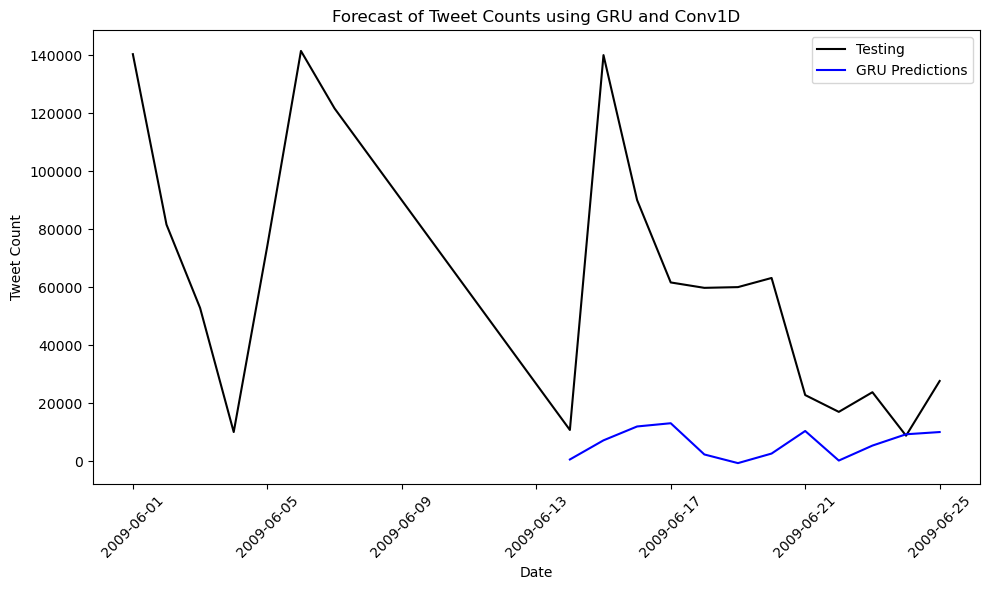

In [41]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')
plt.plot(test.index[sequence_length:], y_pred_gru, color='blue', label='GRU Predictions')
#plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Создаем и обучаем модель с Conv1D слоями
model_conv1d = keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_conv1d.compile(optimizer='adam', loss='mean_squared_error')
model_conv1d.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100
2/2 [==============================] - 2s 250ms/step - loss: 0.1296
Epoch 2/100
2/2 [==============================] - 0s 87ms/step - loss: 0.1088
Epoch 3/100
2/2 [==============================] - 0s 74ms/step - loss: 0.0915
Epoch 4/100
2/2 [==============================] - 0s 67ms/step - loss: 0.0887
Epoch 5/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0751
Epoch 6/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0813
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0779
Epoch 8/100
2/2 [==============================] - 0s 116ms/step - loss: 0.0731
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0798
Epoch 10/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0730
Epoch 11/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0680
Epoch 12/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0648
Epoch 13/100
2/2 [=============================

In [43]:
# Делаем прогноз на тестовой выборке с Conv1D моделью
y_pred_conv1d_scaled = model_conv1d.predict(X_test)
y_pred_conv1d = scaler.inverse_transform(y_pred_conv1d_scaled)

1/1 [==============================] - 0s 107ms/step


Этот код построит график сравнения прогнозов, сделанных с использованием GRU и Conv1D слоев, с исходными значениями тестовой выборки. Это поможет вам оценить, какая модель дает более точные предсказания для вашего временного ряда.

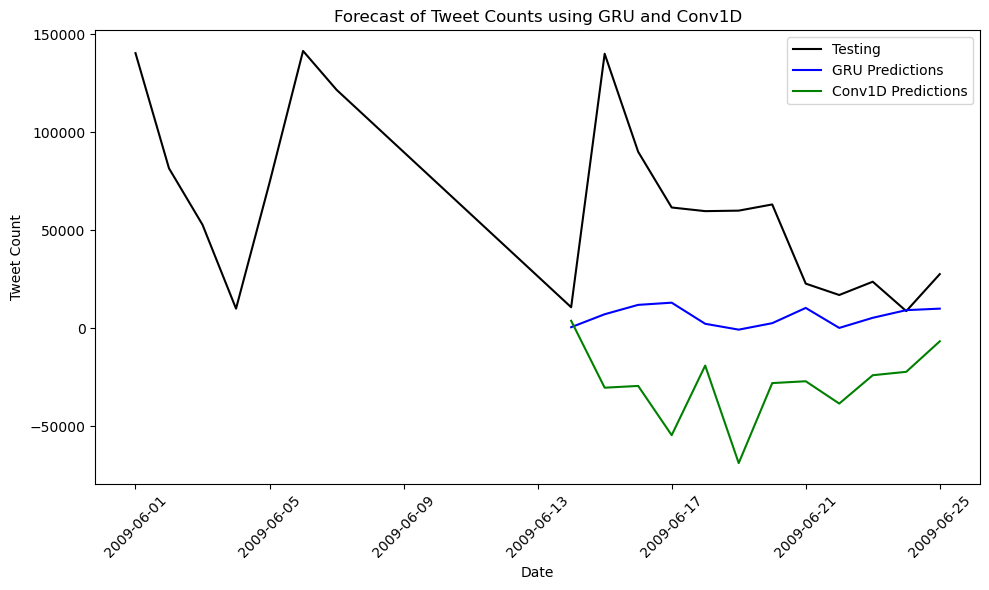

In [44]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')
plt.plot(test.index[sequence_length:], y_pred_gru, color='blue', label='GRU Predictions')
plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Изменим количество нейронов в слоях GRU
model_gru = keras.Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, 1),
        kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    GRU(64, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])



In [46]:
# Изменим скорость обучения (learning rate) оптимизатора Adam
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_gru.compile(optimizer=adam_optimizer, loss='mean_squared_error')

In [47]:
# Увеличим количество эпох обучения
num_epochs = 200

model_gru.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)

Epoch 1/200
2/2 [==============================] - 4s 545ms/step - loss: 1.6993
Epoch 2/200
2/2 [==============================] - 0s 220ms/step - loss: 1.6049
Epoch 3/200
2/2 [==============================] - 0s 161ms/step - loss: 1.5313
Epoch 4/200
2/2 [==============================] - 0s 104ms/step - loss: 1.4492
Epoch 5/200
2/2 [==============================] - 0s 124ms/step - loss: 1.3884
Epoch 6/200
2/2 [==============================] - 0s 78ms/step - loss: 1.3292
Epoch 7/200
2/2 [==============================] - 0s 60ms/step - loss: 1.2750
Epoch 8/200
2/2 [==============================] - 0s 44ms/step - loss: 1.2141
Epoch 9/200
2/2 [==============================] - 0s 65ms/step - loss: 1.1661
Epoch 10/200
2/2 [==============================] - 0s 40ms/step - loss: 1.1176
Epoch 11/200
2/2 [==============================] - 0s 35ms/step - loss: 1.0716
Epoch 12/200
2/2 [==============================] - 0s 33ms/step - loss: 1.0304
Epoch 13/200
2/2 [==========================

2/2 [==============================] - 0s 24ms/step - loss: 0.0498
Epoch 104/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0523
Epoch 105/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0654
Epoch 106/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0597
Epoch 107/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0589
Epoch 108/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0568
Epoch 109/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0571
Epoch 110/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0617
Epoch 111/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0589
Epoch 112/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0578
Epoch 113/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0577
Epoch 114/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0572
Epoch 115/200
2/2 [=======================

In [48]:
# Изменим количество фильтров в слоях Conv1D
model_conv1d = keras.Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

# Изменим скорость обучения (learning rate) оптимизатора Adam
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_conv1d.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Увеличим количество эпох обучения
num_epochs = 200

model_conv1d.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)


Epoch 1/200
2/2 [==============================] - 2s 338ms/step - loss: 0.1393
Epoch 2/200
2/2 [==============================] - 0s 142ms/step - loss: 0.1173
Epoch 3/200
2/2 [==============================] - 0s 132ms/step - loss: 0.1059
Epoch 4/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0920
Epoch 5/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0844
Epoch 6/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0782
Epoch 7/200
2/2 [==============================] - 0s 12ms/step - loss: 0.0755
Epoch 8/200
2/2 [==============================] - 0s 65ms/step - loss: 0.0731
Epoch 9/200
2/2 [==============================] - 0s 12ms/step - loss: 0.0685
Epoch 10/200
2/2 [==============================] - 0s 115ms/step - loss: 0.0709
Epoch 11/200
2/2 [==============================] - 0s 59ms/step - loss: 0.0680
Epoch 12/200
2/2 [==============================] - 0s 19ms/step - loss: 0.0616
Epoch 13/200
2/2 [===========================

2/2 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 104/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0089
Epoch 105/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 106/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 107/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 108/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 109/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 110/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0039
Epoch 111/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 112/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 113/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 114/200
2/2 [==============================] - 0s 11ms/step - loss: 0.0044
Epoch 115/200
2/2 [=======================

In [49]:
# Делаем прогноз на тестовой выборке с GRU моделью
y_pred_gru_scaled = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)

1/1 [==============================] - 1s 524ms/step


In [50]:
# Делаем прогноз на тестовой выборке с Conv1D моделью
y_pred_conv1d_scaled = model_conv1d.predict(X_test)
y_pred_conv1d = scaler.inverse_transform(y_pred_conv1d_scaled)

1/1 [==============================] - 0s 95ms/step


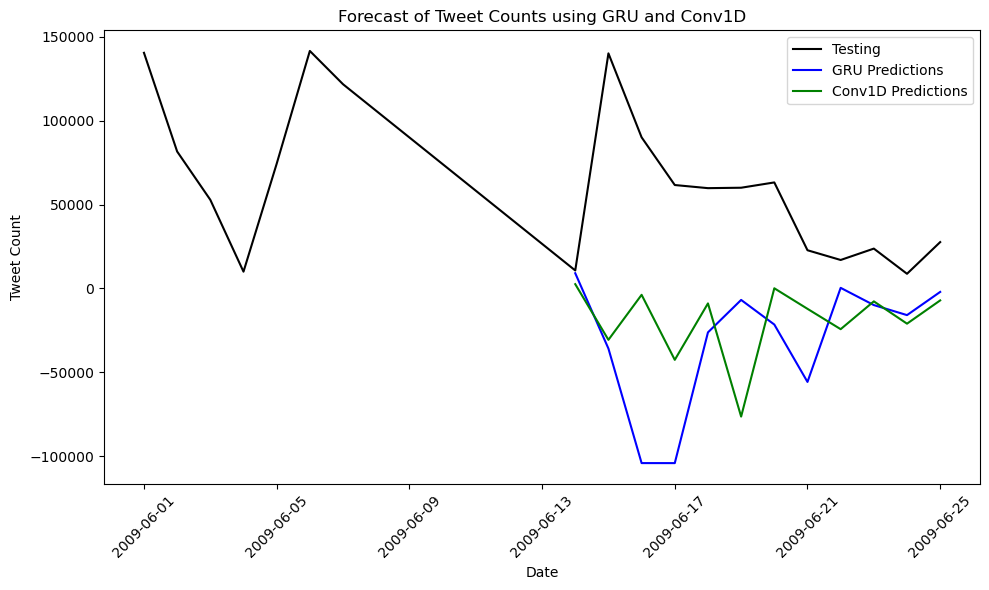

In [51]:
# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')
plt.plot(test.index[sequence_length:], y_pred_gru, color='blue', label='GRU Predictions')
plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/100
2/2 [==============================] - 5s 3s/step - loss: 1.6991 - val_loss: 1.6565
Epoch 2/100
2/2 [==============================] - 1s 234ms/step - loss: 1.6160 - val_loss: 1.5565
Epoch 3/100
2/2 [==============================] - 0s 174ms/step - loss: 1.5296 - val_loss: 1.4744
Epoch 4/100
2/2 [==============================] - 0s 265ms/step - loss: 1.4604 - val_loss: 1.4034
Epoch 5/100
2/2 [==============================] - 0s 259ms/step - loss: 1.3963 - val_loss: 1.3412
Epoch 6/100
2/2 [==============================] - 0s 126ms/step - loss: 1.3339 - val_loss: 1.2846
Epoch 7/100
2/2 [==============================] - 0s 79ms/step - loss: 1.2858 - val_loss: 1.2306
Epoch 8/100
2/2 [==============================] - 0s 136ms/step - loss: 1.2250 - val_loss: 1.1787
Epoch 9/100
2/2 [==============================] - 0s 178ms/step - loss: 1.1728 - val_loss: 1.1288
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 1.1279 - val_loss: 1.0807
Epoch 11/100
2

Epoch 84/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0755 - val_loss: 1.8528
Epoch 85/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0757 - val_loss: 1.7193
Epoch 86/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0770 - val_loss: 1.6058
Epoch 87/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0937 - val_loss: 1.5040
Epoch 88/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0620 - val_loss: 1.4106
Epoch 89/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0661 - val_loss: 1.2991
Epoch 90/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0671 - val_loss: 1.2488
Epoch 91/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0615 - val_loss: 1.3243
Epoch 92/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0697 - val_loss: 1.4333
Epoch 93/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0659 - val_loss: 1.6110
Epoch 94/1

Epoch 67/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0808 - val_loss: 0.0674
Epoch 68/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0758 - val_loss: 0.0674
Epoch 69/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0800 - val_loss: 0.0675
Epoch 70/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0745 - val_loss: 0.0676
Epoch 71/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0806 - val_loss: 0.0675
Epoch 72/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0868 - val_loss: 0.0673
Epoch 73/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0744 - val_loss: 0.0671
Epoch 74/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0837 - val_loss: 0.0669
Epoch 75/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0839 - val_loss: 0.0667
Epoch 76/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0801 - val_loss: 0.0664
Epoch 77/1

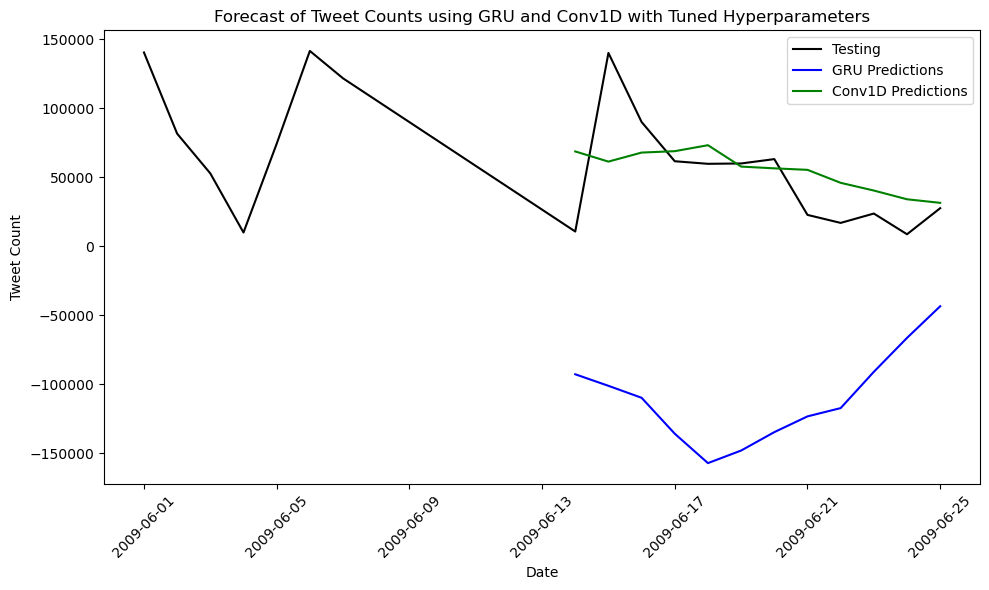

In [70]:
from tensorflow.keras.layers import GRU, Conv1D

# Создаем и обучаем модель с измененными гиперпараметрами для GRU слоев
model_gru = keras.Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, 1),
        kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    GRU(64, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

model_gru.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_test, y_test))

# Создаем и обучаем модель с измененными гиперпараметрами для Conv1D слоев
model_conv1d = keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_conv1d.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
history_conv1d = model_conv1d.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_test, y_test))


# Делаем прогноз на тестовой выборке с обновленными моделями
y_pred_gru_scaled = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)

y_pred_conv1d_scaled = model_conv1d.predict(X_test)
y_pred_conv1d = scaler.inverse_transform(y_pred_conv1d_scaled)

# Визуализируем результаты прогнозов
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')
plt.plot(test.index[sequence_length:], y_pred_gru, color='blue', label='GRU Predictions')
plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D with Tuned Hyperparameters')
plt.legend()
plt.tight_layout()
plt.show()


# Создаем и обучаем модель с измененными гиперпараметрами для Conv1D слоев
model_conv1d = keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_conv1d = keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_conv1d.compile(optimizer='adam', loss='mean_squared_error')
model_conv1d.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

model_conv1d.compile(optimizer='adam', loss='mean_squared_error')

model_conv1d.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [57]:
from keras.layers import GRU

# Создаем и обучаем модель с GRU слоями и dropout
model_gru = keras.Sequential([
    GRU(100, return_sequences=True, input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    GRU(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)



Epoch 1/50
2/2 [==============================] - 4s 445ms/step - loss: 0.1187
Epoch 2/50
2/2 [==============================] - 0s 230ms/step - loss: 0.1009
Epoch 3/50
2/2 [==============================] - 0s 157ms/step - loss: 0.0843
Epoch 4/50
2/2 [==============================] - 0s 183ms/step - loss: 0.0691
Epoch 5/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0730
Epoch 6/50
2/2 [==============================] - 0s 105ms/step - loss: 0.0718
Epoch 7/50
2/2 [==============================] - 0s 105ms/step - loss: 0.0760
Epoch 8/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0786
Epoch 9/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0747
Epoch 10/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0685
Epoch 11/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0710
Epoch 12/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0716
Epoch 13/50
2/2 [==============================] - 0s 5

1/1 [==============================] - 0s 457ms/step


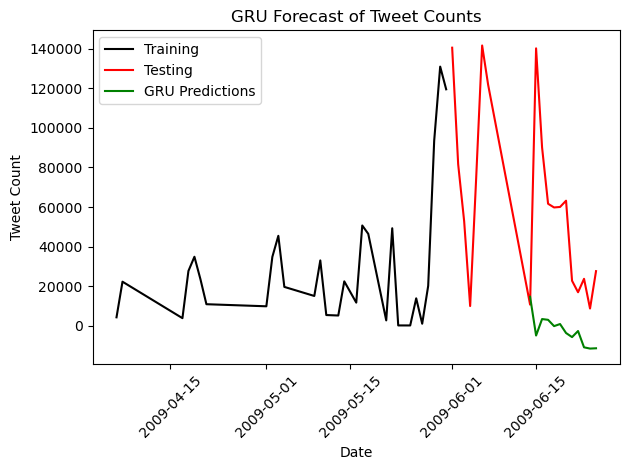

In [58]:
# Делаем прогноз на тестовой выборке
y_pred_scaled = model_gru.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Визуализируем результаты
plt.plot(train.index, train['text'], color='black', label='Training')
plt.plot(test.index, test['text'], color='red', label='Testing')
plt.plot(test.index[sequence_length:], y_pred, color='green', label='GRU Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('GRU Forecast of Tweet Counts')
plt.legend()
plt.tight_layout()
plt.show()

In [111]:
from tensorflow.keras.layers import GRU, Conv1D

# Создаем и обучаем модель с измененными гиперпараметрами для Conv1D слоев
model_conv1d = keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    keras.layers.Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_conv1d.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
history_conv1d = model_conv1d.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_test, y_test))




Epoch 1/100
2/2 [==============================] - 2s 676ms/step - loss: 0.1333 - val_loss: 0.1608
Epoch 2/100
2/2 [==============================] - 0s 263ms/step - loss: 0.1304 - val_loss: 0.1549
Epoch 3/100
2/2 [==============================] - 0s 80ms/step - loss: 0.1374 - val_loss: 0.1492
Epoch 4/100
2/2 [==============================] - 0s 155ms/step - loss: 0.1259 - val_loss: 0.1436
Epoch 5/100
2/2 [==============================] - 0s 114ms/step - loss: 0.1268 - val_loss: 0.1382
Epoch 6/100
2/2 [==============================] - 0s 65ms/step - loss: 0.1262 - val_loss: 0.1330
Epoch 7/100
2/2 [==============================] - 0s 219ms/step - loss: 0.1195 - val_loss: 0.1280
Epoch 8/100
2/2 [==============================] - 0s 146ms/step - loss: 0.1256 - val_loss: 0.1231
Epoch 9/100
2/2 [==============================] - 0s 88ms/step - loss: 0.1226 - val_loss: 0.1184
Epoch 10/100
2/2 [==============================] - 0s 101ms/step - loss: 0.1247 - val_loss: 0.1139
Epoch 11/100

Epoch 84/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0690 - val_loss: 0.0741
Epoch 85/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0671 - val_loss: 0.0744
Epoch 86/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0754 - val_loss: 0.0747
Epoch 87/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0730 - val_loss: 0.0750
Epoch 88/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0586 - val_loss: 0.0753
Epoch 89/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0625 - val_loss: 0.0756
Epoch 90/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0627 - val_loss: 0.0759
Epoch 91/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0637 - val_loss: 0.0763
Epoch 92/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0649 - val_loss: 0.0769
Epoch 93/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0668 - val_loss: 0.0774
Epoch 94/1

1/1 [==============================] - 0s 18ms/step


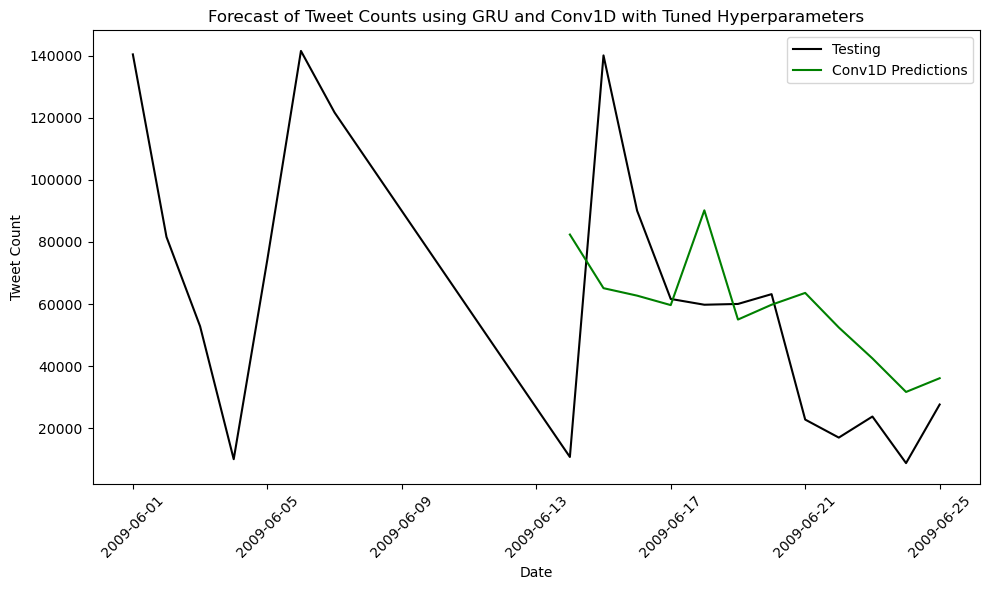

In [113]:
# Делаем прогноз на тестовой выборке с обновленными моделями

y_pred_conv1d_scaled = model_conv1d.predict(X_test)
y_pred_conv1d = scaler.inverse_transform(y_pred_conv1d_scaled)

# Визуализируем результаты прогнозов
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')

plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D with Tuned Hyperparameters')
plt.legend()
plt.tight_layout()
plt.show()


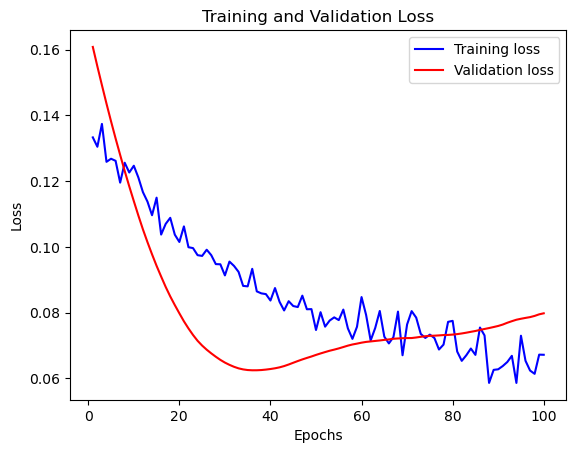

In [114]:
# Получаем историю обучения
loss = history_conv1d.history['loss']
val_loss = history_conv1d.history['val_loss']
epochs = range(1, len(loss) + 1)

# Визуализируем результаты обучения
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


кривые loss и val_loss идут близко друг к другу и уменьшаются, это может указывать на хорошую обобщающую способность модели. 

Text(0.5, 1.0, 'Прогноз количества твитов (Conv1D)')

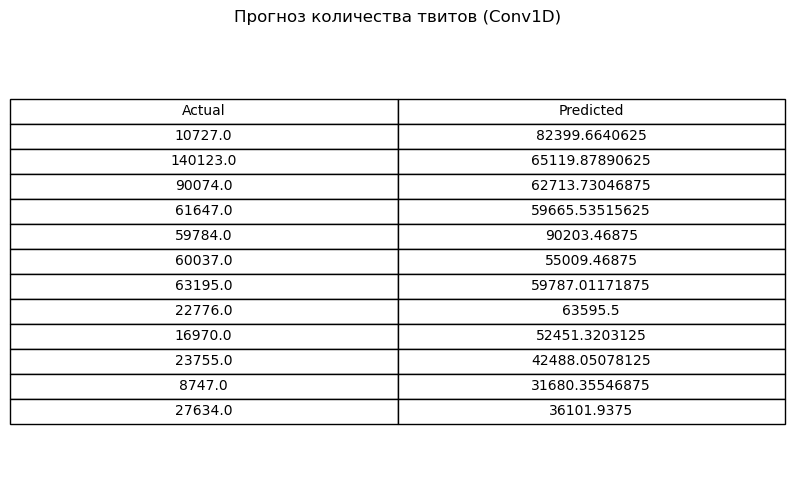

In [115]:
# Обратное нормализование реальных значений (Actual)
actual_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)


# Создаем DataFrame с обратно нормализованными прогнозами и реальными значениями
forecast_table_conv1d = pd.DataFrame({'Actual': actual_unscaled, 'Predicted': y_pred_conv1d.reshape(-1)})
forecast_table_conv1d.index = test.index[sequence_length:]

# Выводим информационную панель для прогноза
fig, ax = plt.subplots(figsize=(10, 6))

# Построение таблицы
ax.axis('off')
table_conv1d = ax.table(cellText=forecast_table_conv1d.values, colLabels=forecast_table_conv1d.columns, cellLoc='center', loc='center')
table_conv1d.auto_set_font_size(False)
table_conv1d.set_fontsize(10)
table_conv1d.scale(1, 1.5)

# Отображение заголовка таблицы
ax.set_title('Прогноз количества твитов (Conv1D)')



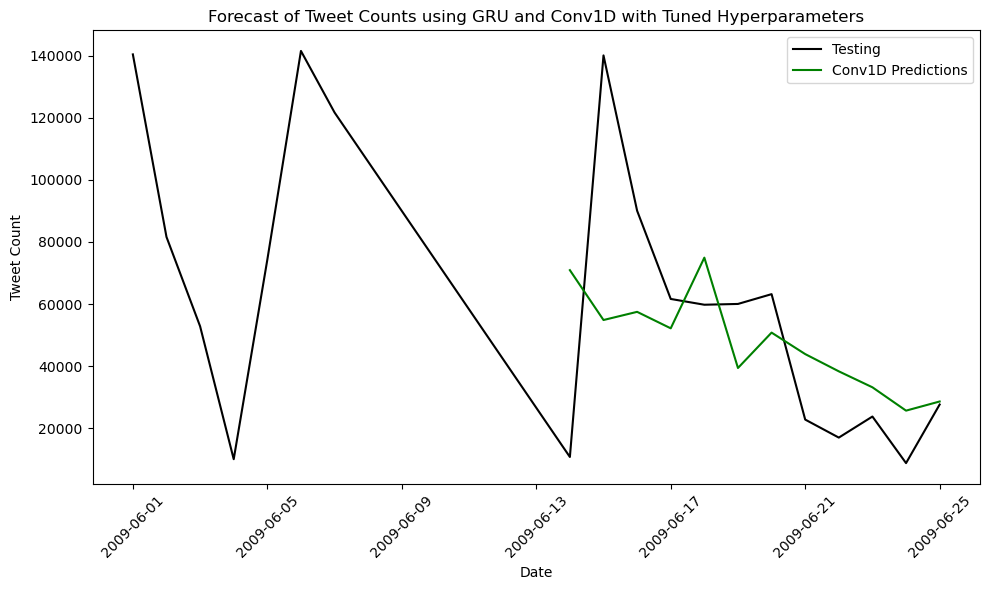

In [110]:
# Визуализируем результаты прогнозов на графике
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['text'], color='black', label='Testing')
plt.plot(test.index[sequence_length:], y_pred_conv1d, color='green', label='Conv1D Predictions')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Forecast of Tweet Counts using GRU and Conv1D with Tuned Hyperparameters')
plt.legend()
plt.tight_layout()
plt.show()
